# 2. Advanced Constrained Optimization

In some situations, certain regions of the solution domain may be infeasible or not allowed. In addition, you may not know whether specific parameter combinations fall into these regions until you have evaluated the constraint function at these points. In other words, checking for feasibility is as expensive, or close to as expensive as evaluating the objective function. This notebook demonstrates how you can handle these situations by modelling the constraints as a Gaussian process. This approach is based on a paper by [Gardner et. al., 2014](http://proceedings.mlr.press/v32/gardner14.pdf).

Note that if the constrained regions are known/if the constraint function is cheap to evaluate, then other approaches are preferable due to the computational complexity of modelling using Gaussian processes.
In this case, at the time of writing the best approach is to return a low number to the optimizer when it tries to evaluate these regions

## 2.1 Simple, single constraint

In [15]:
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint

We illustrate the use of advanced constrained bayesian optimization on the examples Gardner et al. used in their paper.

Define the target function ($f$ or `target_function`) we want to optimize along with a constraint function ($c$ or `constraint_function`) and constraint limit ($c^{lim}$ or `constraint_limit`). The mathematical problem we are trying to solve is
$$
 \max f(x, y)
$$
$$
 \text{subj. to} \: \: c(x, y) \leq c^{\text{lim}}
$$
Note that the constraint function should have the same parameter names as the target function (i.e. in this case `x` and `y`).

In [16]:
def target_function(x, y):
    # Gardner is looking for the minimum, but this packages looks for maxima, thus the sign switch
    return np.cos(2*x)*np.cos(y) + np.sin(x)

def constraint_function(x, y):
    return np.cos(x) * np.cos(y) - np.sin(x) * np.sin(y)

constraint_limit = 0.5

A `scipy.NonlinearConstraint` object stores the constraint configuration. Since we do not have a lower bound on our problem, provide `-np.inf` as `lb` argument.

In [17]:
constraint = NonlinearConstraint(constraint_function, -np.inf, constraint_limit)

Create a `BayesianOptimization` model as you would usually, providing the `ConstraintModel` instance as additional keyword argument.  

In [18]:
# Bounded region of parameter space
pbounds = {'x': (0, 6), 'y': (0, 6)}

optimizer = BayesianOptimization(
    f=target_function,
    constraint=constraint,
    pbounds=pbounds,
    verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

Run the optimization as usual -- the optimizer automatically estimates the probability for the constraint to be fulfilled and modifies the acquisition function accordingly. This means, that the optimizer avoids sampling points that are likely unfeasible.

In [19]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

The best combination of parameters, target value and constraint function value found by the optimizer can be accessed via the property `optimizer.max`.

In [20]:
print(optimizer.max)

{'target': 1.7926580410885493, 'params': {'x': 1.8544556027555315, 'y': 2.9819440360534406}, 'constraint': 0.1236930501262351}


In [7]:
def plot_constrained_opt(pbounds, target_function, optimizer):
    """
    Plots a number of interesting contours to visualize constrained 2-dimensional optimization.
    """

    # Set a few parameters
    n_constraints = optimizer.constraint.lb.size
    n_plots_per_row = 2+n_constraints

    # Construct the subplot titles
    if n_constraints==1:
        c_labels = ["constraint"]
    else:
        c_labels = [f"constraint {i+1}" for i in range(n_constraints)]
    labels_top = ["target"] + c_labels + ["masked target"]
    labels_bot = ["target estimate"] + [c + " estimate" for c in c_labels] + ["acqusition function"]
    labels = [labels_top, labels_bot]

    # Setup the grid to plot on
    x = np.linspace(pbounds['x'][0], pbounds['x'][1], 1000)
    y = np.linspace(pbounds['y'][0], pbounds['y'][1], 1000)
    xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
    X, Y = np.meshgrid(x, y)

    # Evaluate the actual functions on the grid
    Z = target_function(X, Y)
    # This reshaping is a bit painful admittedly, but it's a consequence of np.meshgrid
    C = optimizer.constraint.fun(X, Y).reshape((n_constraints,) + Z.shape).swapaxes(0, -1)
    
    
    fig, axs = plt.subplots(2, n_plots_per_row, constrained_layout=True, figsize=(12,8))

    for i in range(2):
        for j in range(n_plots_per_row):
            axs[i, j].set_aspect("equal")
            axs[i, j].set_title(labels[i][j])
    
    
    # Extract & unpack the optimization results
    max_ = optimizer.max
    res = optimizer.res
    x_ = np.array([r["params"]['x'] for r in res])
    y_ = np.array([r["params"]['y'] for r in res])
    c_ = np.array([r["constraint"] for r in res])
    a_ = np.array([r["allowed"] for r in res])


    Z_est = optimizer._gp.predict(xy).reshape(Z.shape)
    C_est = optimizer.constraint.approx(xy).reshape(Z.shape + (n_constraints,))
    P_allowed = optimizer.constraint.predict(xy).reshape(Z.shape)

    Acq = np.where(Z_est >0, Z_est * P_allowed, Z_est / (0.5 + P_allowed))
    
    
    target_vbounds = np.min([Z, Z_est]), np.max([Z, Z_est])
    constraint_vbounds = np.min([C, C_est]), np.max([C, C_est])


    axs[0,0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
    for i in range(n_constraints):
        axs[0,1+i].contourf(X, Y, C[:,:,i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
    Z_mask = Z

    Z_mask[~np.squeeze(optimizer.constraint.allowed(C))] = np.nan
    axs[0,n_plots_per_row-1].contourf(X, Y, Z_mask, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])

    axs[1,0].contourf(X, Y, Z_est, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
    for i in range(n_constraints):
        axs[1,1+i].contourf(X, Y, C_est[:, :, i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
    axs[1,n_plots_per_row-1].contourf(X, Y, Acq, cmap=plt.cm.coolwarm, vmin=0, vmax=1)

    for i in range(2):
        for j in range(n_plots_per_row):
            axs[i,j].scatter(x_[a_], y_[a_], c='white', s=80, edgecolors='black')
            axs[i,j].scatter(x_[~a_], y_[~a_], c='red', s=80, edgecolors='black')
            axs[i,j].scatter(max_["params"]['x'], max_["params"]['y'], s=80, c='green', edgecolors='black')

    return fig, axs

We will now visualize the constrained optimization.

In the following figure you will see two rows of plots with 3 quadratic plots each. The top row contains - in order -- contour visualizations of the target function, constraint function and the target function (masked such that only areas where the constraint is fulfilled are plotted). Additionally we have visualized the points sampled by the optimizer -- the optimal point is plotted in green, allowed (but non-optimal) points in white, and disallowed points in red. The bottom row shows -- in order -- the approximation of the target function using the gaussian regressors, the approximation of the constraint function and a visualization of the acquisition function, i.e. the function that guides the next point to sample.

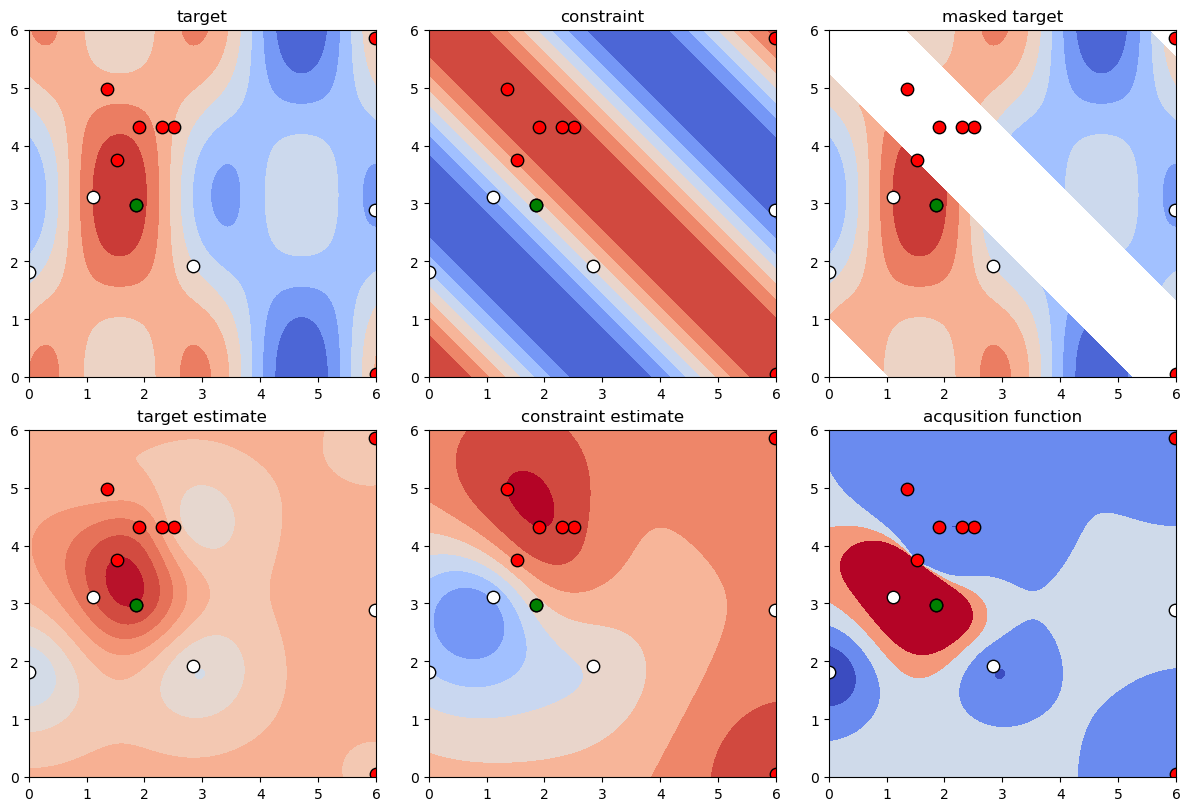

In [8]:
plot_constrained_opt(pbounds, target_function, optimizer);

## Simulation 2

We proceed with another slightly different problem of the same form. Here, we place a constraint from above and below on a function value.
$$
 \max f(x, y)
$$
$$
 \text{subj. to} \: \: c^{\text{low}} \leq c(x, y) \leq c^{\text{up}}
$$

In [9]:
def target_function(x, y):
    # Gardner is looking for the minimum, but this packages looks for maxima, thus the sign switch
    return np.sin(x) + y

def constraint_function(x, y):
    return np.sin(x) * np.sin(y)

# Note that the constraint limit in case of one-dimensional constraints can be both an array of shape (1,) or a number.
constraint_lower = np.array([-0.9])
constraint_upper = np.array([-0.3])

In [10]:
constraint = NonlinearConstraint(constraint_function, constraint_lower, constraint_upper)

optimizer = BayesianOptimization(
    f=target_function,
    constraint=constraint,
    pbounds=pbounds,
    verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=10,
)

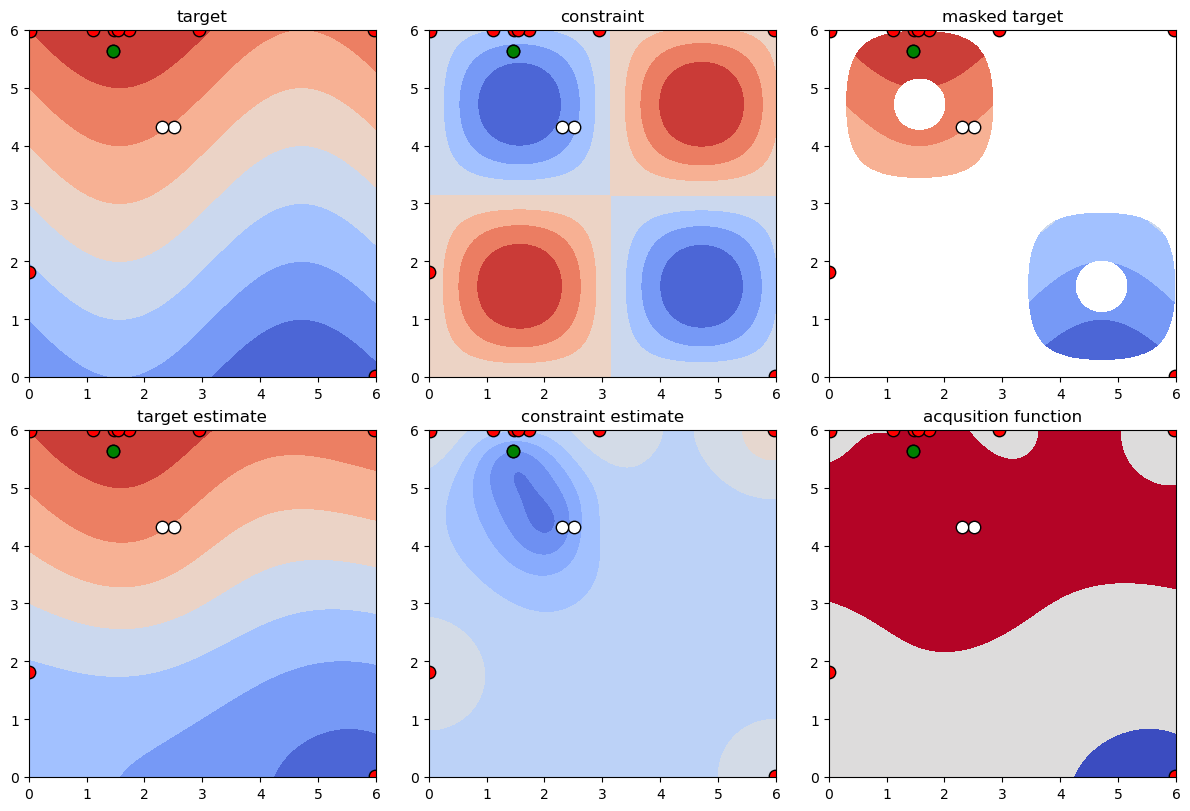

In [11]:
plot_constrained_opt(pbounds, target_function, optimizer);

### 2.2 Multiple Constraints

Occasionally, one might need to fulfill multiple constraints. In this case, simply employ a multi-dimensional surrogate constraint function, i.e., in case of `n` constraints, a function returning an array of shape `(n,)`. Similarly, the `constraint_limit` should be an array of shape `(n,)`. The problem we are solving is
$$
 \max f(x, y)
$$
$$
 \text{subj. to} \: \: c_1^{\text{low}} \leq c_1(x, y) < c_1^{\text{up}}
$$
$$
 \text{subj. to} \: \: c_2^{\text{low}} \leq c_2(x, y) < c_2^{\text{up}}
$$
$$
 \dots
$$
$$
 \text{subj. to} \: \: c_n^{\text{low}} \leq c_n(x, y) < c_n^{\text{up}}
$$ 

In [12]:
def target_function(x, y):
    # Gardner is looking for the minimum, but this packages looks for maxima, thus the sign switch
    return np.cos(2*x)*np.cos(y) + np.sin(x)

def constraint_function_2_dim(x, y):
    return np.array([
        - np.cos(x) * np.cos(y) + np.sin(x) * np.sin(y),
        - np.cos(x) * np.cos(-y) + np.sin(x) * np.sin(-y)])

constraint_lower = np.array([-np.inf, -np.inf])
constraint_upper = np.array([0.6, 0.6])

Construct the problem is you would in the single-constraint case and run the optimization. Note that internally the optimizer assumes conditional independence between multiple constraints.

In [13]:
constraint = NonlinearConstraint(constraint_function_2_dim, constraint_lower, constraint_upper)
optimizer = BayesianOptimization(
    f=target_function,
    constraint=constraint,
    pbounds=pbounds,
    verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=10,
)

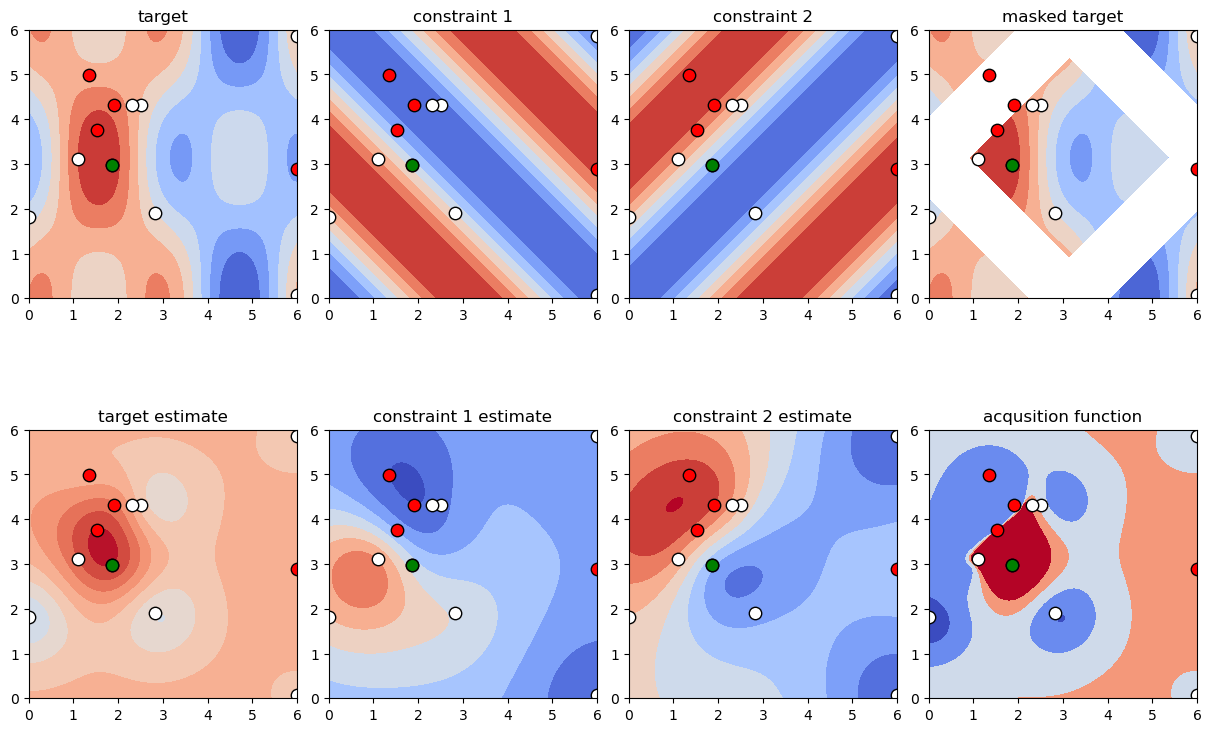

In [14]:
plot_constrained_opt(pbounds, target_function, optimizer);